In [5]:
import pandas as pd
import numpy as np
import re
import sys
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Importing all three datasets as separate CSV files.

In [6]:
# Specifying the data location
data_path = "/Users/SuZal/Downloads/KPMG/Data"

# Checking if the current path is same as the data location. If not changing the directory to directory containing data
if os.getcwd() != data_path:
    os.chdir(data_path)

# Creating Empty Dictionary to hold our data
my_data = {} 

# Reading all csv files and storing the data as pandas framework in a dictionary with filename as the key.
for each_file in os.listdir():
    print(each_file)
    dict_key = each_file.split('.')[0]
    my_data[dict_key] = pd.read_csv(each_file,skiprows=1)
my_data.keys()

new_customers.csv
all_customers.csv
customer_demographics.csv
customer_address.csv
transactions.csv


dict_keys(['new_customers', 'all_customers', 'customer_demographics', 'customer_address', 'transactions'])

# Let's work at one data at a time
## Working on new customers data

In [7]:
# let's take a quick glance on the data
df = my_data['new_customers']
df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6.0,1.06,1.325,1.65625,1.407812,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11.0,1.08,1.080,1.35000,1.147500,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5.0,0.69,0.690,0.69000,0.690000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1.0,0.80,1.000,1.00000,1.000000,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9.0,0.41,0.410,0.51250,0.512500,4,4,1.703125


### Step1.  Checking for completeness of the data
Finding if any values are missing from the data.

In [8]:
print("Columns with Missing Values")
for each_columns in df.columns:
    if df[each_columns].isna().any():
        print(each_columns)
        print("Total Missing Values:",df[each_columns].isna().sum())

Columns with Missing Values
last_name
Total Missing Values: 29
DOB
Total Missing Values: 17
job_title
Total Missing Values: 106
job_industry_category
Total Missing Values: 165


## Step 2. Validating the data

Checking if the entries on DOB column are in specified format or not and calculating Age based on DOB. If the age of customer is more than 110 the data would be suspicious and sent for inspection and correction.

In [9]:
# DOB Matching Using Regex
# Formatting used yyyy/mm/dd or yyyy-mm-dd or yyyy\mm\dd
# If the order is mixed simply re-arrange 
# the year,month and day sections in any order required.

Date_Of_Birth_regex = re.compile(r'''(
([1-2]\d{3}) #Year should be in range 1000-2999
(- | / | \\) #Separator add | and separators used
([1-9] | 0[1-9] | 1[0-2]) #Month should be in range 1-12
(- | / | \\) #Separator add | and separators used
([1-9] | 0[1-9] | [1-2][0-9] | 3[0-1]) #Day should be in range 1-31
)''',re.VERBOSE)

# Given a dataframe with DOB values in a column named DOB 
# returns the age for valid entries and 0 for invalid DOB entries.

def calculate_age(row):
    birth_date = str(row['DOB']).strip()            
    DOB_found = Date_Of_Birth_regex.search(birth_date)
    if DOB_found:
        return int(datetime.today().year) - int(DOB_found.group(2))
    else:
        return 0

N    1000
Name: deceased_indicator, dtype: int64

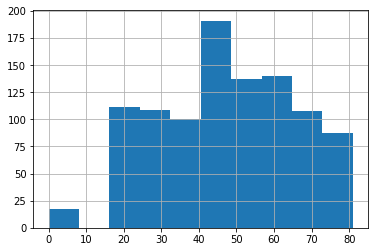

In [10]:
# Plotting a histogram to see how customer age is distributed 
# and to find any outlying values.
df['Age'] = df.apply(lambda row: calculate_age(row), axis=1)
df['Age'].hist(bins=10)
df['deceased_indicator'].value_counts()

The above histogram shows that there are 17 missing values in DOB. There are no values with Age higher than 82, which gives us a sense that the DOB values are true and valid. We have also taken into account the deceased indicator such that if a person is of age more than 110 and has deceased indicator of Y, the data entry can be cosnidered true.

In [11]:
df['last_name'].fillna("na")
len(df.drop_duplicates(['first_name','last_name']))

1000

Dropping duplicates using first and last name suggest that even if the data is missing 27 values in last name all the 1000 customers can still be uniquely identified using their first and last name combination.

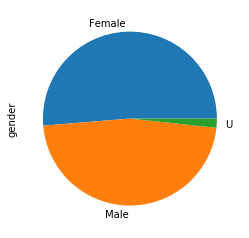

In [12]:
df['gender'].value_counts()
df['gender'].value_counts().plot(kind='pie')

Above chart suggests that there are no any unwanted or invalid entries for gender column.

count    1000.000000
mean       49.836000
std        27.796686
min         0.000000
25%        26.750000
50%        51.000000
75%        72.000000
max        99.000000
Name: past_3_years_bike_related_purchases, dtype: float64


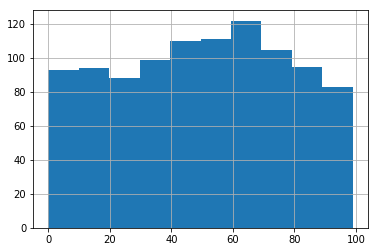

In [15]:
df['past_3_years_bike_related_purchases'].hist(bins=10)
print(df['past_3_years_bike_related_purchases'].describe())

The above graphs and statistics suggests there are no any unusual and all the values for the column are inside considerable range.

# Validating Address
This section validates the customer address with valid Australian address. The address must consist of a house number, street name, suburb name(optional), state and postcode(optional).

In [16]:
# Use case: change the address to lowercase before matching the regex
# Matching the australian address in the following format 
# unit_number street_number street_name, Suburb State Country Postcode

Address_Regex = re.compile(r'''(
(u | unit)? # adress may be unit (unit_number) (street number) ...
(\s)?
(\d+\s?\w?)? # Unit number can be 10, 10A etc
(\/|\s)?
(\d+) # Street number
(th | st | nd | rd)? # th,nd,rd and st that can follow the steet number e.g. 4th street
(\s)
(\w+ | \w+\s\w+ | \w+\s\w+\s\w+ | \w+\s\w+\s\w+\s\w+) # Street Name can be from 1 word to 4 word
(,) # This comma is mandatory for matching the street name
(\w+ | \w+\s\w+)?  # Suburb Name can be one or two words eg: Wilson, High Wycombe
(\s)?
(\w{2,3}) # State (Australia has state names that are represented by either two or three letters e.g. WA, VIC,NSW)
(\s)
(\w+) # Country
(\s)
(\d{4})? # Postcode Australian postcode is strictly 4 digit eg. 6107
)''',re.VERBOSE)


# Given a dataframe with full address divided into multiple columns 
# return a true value if full address is a valid address and zero if the address is invalid.

def validate_address(row):
    full_address = str(row['address']).strip()+","+str(row['state']).strip()+" "+str(row['country']).strip()+" "+str(row['postcode']).strip()         
    Valid_Address = Address_Regex.search(full_address)
    if Valid_Address:
        return 1
    else:
        return 

In [17]:
# Replacing long names of state by short names for address matching
Replace_long_name_to_short = {"New South Wales": "NSW","Victoria": "VIC","Western Australia":"WA","South Australia":"SA","Northern Territory":"NT","Tasmania":"TAS","Queensland":"QLD"}
df['state'].update(pd.Series(Replace_long_name_to_short))

# Checking if there are still some data that needs to be replaced
print(df['state'].value_counts())
print(df['country'].value_counts())

NSW    506
VIC    266
QLD    228
Name: state, dtype: int64
Australia    1000
Name: country, dtype: int64


In [18]:
# Matching Address
df['Valid_Address'] = df.apply(lambda row: validate_address(row), axis=1)
print("Total Addresses Matched:",df['Valid_Address'].sum())

#Show Invalid Addresses if there are some invalid addresses
if df['Valid_Address'].sum() < len(df):
    print("Invalid Addresses:")
    df[df['Valid_Address']==0][['address','state','country','postcode']]

Total Addresses Matched: 1000


## Exploring Remaining Columns
Remaining columns are examined for data validity and consistency.

In [19]:
df.past_3_years_bike_related_purchases.describe()

count    1000.000000
mean       49.836000
std        27.796686
min         0.000000
25%        26.750000
50%        51.000000
75%        72.000000
max        99.000000
Name: past_3_years_bike_related_purchases, dtype: float64

In [20]:
df.wealth_segment.value_counts()

Mass Customer        508
High Net Worth       251
Affluent Customer    241
Name: wealth_segment, dtype: int64

In [21]:
df.tenure.describe()

count    1000.000000
mean       11.388000
std         5.037145
min         0.000000
25%         7.000000
50%        11.000000
75%        15.000000
max        22.000000
Name: tenure, dtype: float64

In [22]:
df.property_valuation.describe()

count    1000.000000
mean        7.397000
std         2.758804
min         1.000000
25%         6.000000
50%         8.000000
75%         9.000000
max        12.000000
Name: property_valuation, dtype: float64

In [23]:
df.Rank.describe()

count    1000.000000
mean      498.819000
std       288.810997
min         1.000000
25%       250.000000
50%       500.000000
75%       750.250000
max      1000.000000
Name: Rank, dtype: float64

In [24]:
df.Value.describe()

count    1000.000000
mean        0.881714
std         0.293525
min         0.340000
25%         0.649531
50%         0.860000
75%         1.075000
max         1.718750
Name: Value, dtype: float64

The values and range for these columns seems to be valid and data can be considered complete for these columns.

## The Next step. Preparing our data to merge with existing customer Data
#### Since we already have 4000 customers in our existing customer demographics and address data lets assign our new customers a unique customer ID starting from 4005. 

In [25]:
df['customer_id'] = range(4005,4005+len(df))
df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value,Age,Valid_Address,customer_id
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,1.06,1.325,1.65625,1.407812,1,1,1.718750,62,1,4005
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,1.08,1.080,1.35000,1.147500,1,1,1.718750,49,1,4006
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,0.69,0.690,0.69000,0.690000,1,1,1.718750,45,1,4007
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,0.80,1.000,1.00000,1.000000,4,4,1.703125,40,1,4008
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,0.41,0.410,0.51250,0.512500,4,4,1.703125,54,1,4009


In [26]:
# Rearranging columns and saving the dataframe to our local variable
#cols = df.columns.tolist()
#df = df[cols]
my_data['new_customers']=df

## Let's start working on other data.
Working on Customer Demographics Data

In [29]:
# Quick Glance at the dataset.
customer_demo_df = my_data['customer_demographics']
customer_demo_df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,1-Feb,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


## Step 1. Checking for the completeness of the data.

In [31]:
#Checking na Values
for each_col in customer_demo_df.columns:
    if customer_demo_df[each_col].isna().any():
        print("For column", each_col,end="\t")
        print("There are ",customer_demo_df[each_col].isna().sum(), "missing values")

For column last_name	There are  125 missing values
For column DOB	There are  87 missing values
For column job_title	There are  506 missing values
For column job_industry_category	There are  656 missing values
For column default	There are  302 missing values
For column tenure	There are  87 missing values


## Step 2. Validating DOB data column and calculating age of customers.

In [33]:
# Checking if there are invalid entries for DOB.
customer_demo_df['Age']= customer_demo_df.apply(lambda row: calculate_age(row), axis=1)

# If the customer's age appears to be more than 110, the entry will be flagged as invalid.
Invalid_DOBs = customer_demo_df[customer_demo_df.Age >= 110]
if len(Invalid_DOBs) >0:
    print("There are",len(Invalid_DOBs),"invalid DOB's please check the following Entries")
    print()
    print(Invalid_DOBs[['customer_id','first_name','last_name','DOB','Age']])

There are 1 invalid DOB's please check the following Entries

    customer_id first_name last_name         DOB  Age
33           34   Jephthah  Bachmann  1843-12-21  176


In [34]:
# Exploring if the gender value have invalid Entries
customer_demo_df.gender.value_counts()

Female    2037
Male      1872
U           88
Femal        1
F            1
M            1
Name: gender, dtype: int64

Since the gender column have values like Female, Femal, F,M, U to identify the gender we will merge them into three values with just F,M and U.

In [35]:
# Replacing Gender Values from long names to short. E.g. Female to F and Male to M

customer_demo_df['gender']=customer_demo_df['gender'].replace(to_replace=r'^F\w+$', value='F', regex=True)
customer_demo_df['gender']=customer_demo_df['gender'].replace(to_replace=r'^M\w+$', value='M', regex=True)
customer_demo_df['gender']=customer_demo_df['gender'].replace(to_replace=r'^U\w+$', value='U', regex=True)

In [36]:
# Chekcing how may types of entries we have now for the gender column
customer_demo_df.gender.value_counts()

F    2039
M    1873
U      88
Name: gender, dtype: int64

### Exploring remaining columns for validity and Consistency

count    4000.000000
mean       48.890000
std        28.715005
min         0.000000
25%        24.000000
50%        48.000000
75%        73.000000
max        99.000000
Name: past_3_years_bike_related_purchases, dtype: float64


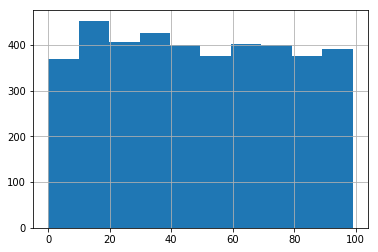

In [38]:
print(customer_demo_df.past_3_years_bike_related_purchases.describe())
customer_demo_df.past_3_years_bike_related_purchases.hist(bins=10)

In [39]:
customer_demo_df.wealth_segment.value_counts()

Mass Customer        2000
High Net Worth       1021
Affluent Customer     979
Name: wealth_segment, dtype: int64

In [40]:
customer_demo_df.deceased_indicator.value_counts()

print("Deceased Customers")
customer_demo_df[customer_demo_df.deceased_indicator == "Y"][['customer_id','first_name','last_name','DOB','Age','deceased_indicator']]

Deceased Customers


,customer_id,first_name,last_name,DOB,Age,deceased_indicator
752,753,Josy,St. Quentin,1970-03-07,49,Y
3789,3790,Kurtis,Morson,1959-05-31,60,Y


In [41]:
customer_demo_df.owns_car.value_counts()

Yes    2024
No     1976
Name: owns_car, dtype: int64

In [42]:
customer_demo_df.tenure.describe()

count    3913.000000
mean       10.657041
std         5.660146
min         1.000000
25%         6.000000
50%        11.000000
75%        15.000000
max        22.000000
Name: tenure, dtype: float64

The values and range for the columns seems to be valid and data can be considered complete for these columns.

## Working on customer address data
Let's explore customer address data and then join customer address data with customer demographics data using customer ID as primary key.

In [44]:
# Having Quick glance at the data.
customer_add_df = my_data['customer_address']
customer_add_df.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


## Step 1. Checking the completeness of the data.
Finding any null values in the data

In [45]:
#Checking na Values
for each_col in customer_add_df.columns:
    if customer_add_df[each_col].isna().any():
        print("For column", each_col,end="\t")
        print("There are ",customer_add_df[each_col].isna().sum(), "missing values")
    else:
        print("There are no missing Values")

There are no missing Values
There are no missing Values
There are no missing Values
There are no missing Values
There are no missing Values
There are no missing Values


## Step 2. Address Validation
Same address validation is used to verify the addresses.

In [47]:
# Validating the addresses.
# For validating address we need to chance long state names with shorter representation for uniformity.
# Technique 1 with Regex
customer_add_df['state']=customer_add_df['state'].replace(to_replace=r'^N\w+\s?S\w+\s?W\w+$', value='NSW', regex=True)

# Technique 2 with dictionary 
# Replacing long names of state by short names for address matching
Replace_long_name_to_short = {"New South Wales": "NSW","Victoria": "VIC","Western Australia":"WA","South Australia":"SA","Northern Territory":"NT","Tasmania":"TAS","Queensland":"QLD"}
customer_add_df['state']=customer_add_df['state'].replace(to_replace=Replace_long_name_to_short.keys(), value=Replace_long_name_to_short.values())

# Checking if there are still some data that needs to be replaced
customer_add_df.state.value_counts()

NSW    2140
VIC    1021
QLD     838
Name: state, dtype: int64

In [48]:
# Matching Address
customer_add_df['Valid_Address'] = customer_add_df.apply(lambda row: validate_address(row), axis=1)
print("Total Addresses Matched:",customer_add_df['Valid_Address'].sum())

#Show Invalid Addresses if there are some invalid addresses
if customer_add_df['Valid_Address'].sum() < len(customer_add_df):
    print("Invalid Addresses:")
    customer_add_df[customer_add_df['Valid_Address']==0][['address','state','country','postcode']]
else:
    print("All Addresses Matched")

Total Addresses Matched: 3999
All Addresses Matched


In [49]:
customer_add_df.customer_id.describe()

count    3999.000000
mean     2003.987997
std      1154.576912
min         1.000000
25%      1004.500000
50%      2004.000000
75%      3003.500000
max      4003.000000
Name: customer_id, dtype: float64

There is some discontinuity in customer ID and some customer ID is missing.
Finding the missing customer ID's.

In [53]:
# Finding Missing Id's in customer address database.
customer_ids = customer_add_df['customer_id'].unique()
missing_ids = [y for y in range(1, 4000+1) if y not in customer_ids]
if len(missing_ids)>0:
    print("Missing customer ids in customer Demographic Data")
    print(missing_ids)
else:
    print("No missing ID's")

Missing customer ids in customer Demographic Data
[3, 10, 22, 23]


In [54]:
# Checking if ID's are missing from customer demographics dataset as well.
customer_ids = customer_demo_df['customer_id'].unique()
missing_ids = [y for y in range(1, 4000+1) if y not in customer_ids]
if len(missing_ids)>0:
    print("Missing customer ids in customer Demographic Data")
    print(missing_ids)
else:
    print("No missing ID's")

No missing ID's


## There is some serious concern here.
Four customer ids namely customer ID 3,10,22 and 23 are missing from the customer address dataset. May be this is caused by some indexing error becuase we only have data upto customer ID 4000 in the customer demographics data but the customer id is upto 4003 in customer address dataset. There are no anyother overlapping columns except the customer id in these two datasets which can be used as a validating factor while merging the data. 

Assuming that the data is valid and the customer ID on customer address data is true we proceed further on joining two data using cutomer id column.

In [55]:
merged_customer_data = pd.merge(customer_demo_df,customer_add_df,on=['customer_id'],how='outer')
len(merged_customer_data)

4003

In [56]:
merged_customer_data.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,Age,address,postcode,state,country,property_valuation,Valid_Address
0,1,Laraine,Medendorp,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0,66.0,060 Morning Avenue,2016.0,NSW,Australia,10.0,1.0
1,2,Eli,Bockman,M,81.0,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0,39.0,6 Meadow Vale Court,2153.0,NSW,Australia,10.0,1.0
2,3,Arlin,Dearle,M,61.0,1954-01-20,Recruiting Manager,Property,Mass Customer,N,1-Feb,Yes,15.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Talbot,NaN,M,33.0,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0,58.0,0 Holy Cross Court,4211.0,QLD,Australia,9.0,1.0
4,5,Sheila-kathryn,Calton,F,56.0,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0,42.0,17979 Del Mar Point,2448.0,NSW,Australia,4.0,1.0


## Merging New Customer Data with Existing customer Data.
After Merging the customer demographics and customer address database, we now proceed with merging the new customers database with existing customer database.

In [57]:
df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value,Age,Valid_Address,customer_id
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,1.06,1.325,1.65625,1.407812,1,1,1.718750,62,1,4005
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,1.08,1.080,1.35000,1.147500,1,1,1.718750,49,1,4006
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,0.69,0.690,0.69000,0.690000,1,1,1.718750,45,1,4007
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,0.80,1.000,1.00000,1.000000,4,4,1.703125,40,1,4008
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,0.41,0.410,0.51250,0.512500,4,4,1.703125,54,1,4009


In [58]:
print(merged_customer_data.columns)
print(df.columns)

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure', 'Age', 'address', 'postcode', 'state',
       'country', 'property_valuation', 'Valid_Address'],
      dtype='object')
Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value', 'Age', 'Valid_Address',
       'customer_id'],
      dtype='object')


In [72]:
df = df.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18','Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value'])
df.columns

Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Age', 'Valid_Address'],
      dtype='object')

In [73]:
# Rearranging columns to bring customer_id column to the front
columns = list(df.columns)
columns.remove('customer_id')
columns = ['customer_id'] + columns
df = df[columns]
df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,Age,Valid_Address
0,4005,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,14,45 Shopko Center,4500,QLD,Australia,6.0,62,1
1,4006,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,16,14 Mccormick Park,2113,NSW,Australia,11.0,49,1
2,4007,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,10,5 Colorado Crossing,3505,VIC,Australia,5.0,45,1
3,4008,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,5,207 Annamark Plaza,4814,QLD,Australia,1.0,40,1
4,4009,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,19,115 Montana Place,2093,NSW,Australia,9.0,54,1


# Merging New Customers with Existing Customers.
We now merge new customers with existing customers and save the resulting data into a file named all_customers.csv

In [74]:
all_customers = pd.merge(merged_customer_data,df,on=columns,how='outer')

In [75]:
all_customers.tail()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure,Age,address,postcode,state,country,property_valuation,Valid_Address
4998,5000,Ferdinand,Romanetti,Male,60.0,1959-10-07,Paralegal,Financial Services,Affluent Customer,N,NaN,No,9.0,60.0,2 Sloan Way,2200.0,NSW,Australia,7.0,1.0
4999,5001,Burk,Wortley,Male,22.0,2001-10-17,Senior Sales Associate,Health,Mass Customer,N,NaN,No,6.0,18.0,04 Union Crossing,2196.0,NSW,Australia,10.0,1.0
5000,5002,Melloney,Temby,Female,17.0,1954-10-05,Budget/Accounting Analyst IV,Financial Services,Affluent Customer,N,NaN,Yes,15.0,65.0,33475 Fair Oaks Junction,4702.0,QLD,Australia,2.0,1.0
5001,5003,Dickie,Cubbini,Male,30.0,1952-12-17,Financial Advisor,Financial Services,Mass Customer,N,NaN,Yes,19.0,67.0,57666 Victoria Way,4215.0,QLD,Australia,2.0,1.0
5002,5004,Sylas,Duffill,Male,56.0,1955-10-02,Staff Accountant IV,Property,Mass Customer,N,NaN,Yes,14.0,64.0,21875 Grover Drive,2010.0,NSW,Australia,9.0,1.0


In [76]:
all_customers.to_csv(r'/Users/SuZal/Downloads/KPMG/Data/all_customers.csv', index = None, header=True) 

# Let's explore Transactions Data

In [89]:
# Quick glance over the transaction Data.
df = my_data['transactions']
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,valid_date,valid_first_sold_date
0,1,2,2950,25/02/2017,False,Approved,Solex,Standard,medium,medium,71.49,53.62,02/12/2012,1,1
1,2,3,3120,21/05/2017,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,03/03/2014,1,1
2,3,37,402,16/10/2017,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,20/07/1999,1,1
3,4,88,3135,31/08/2017,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,16/12/1998,1,1
4,5,78,787,01/10/2017,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,10/08/2015,1,1


## Step 1. Checking Completeness of the Data
Finding Null values in the data

In [90]:
# Checking for Null Values
#Checking na Values
for each_col in df.columns:
    if df[each_col].isna().any():
        print("For column", each_col,end="\t")
        print("There are ",df[each_col].isna().sum(), "missing values")

For column online_order	There are  360 missing values
For column brand	There are  197 missing values
For column product_line	There are  197 missing values
For column product_class	There are  197 missing values
For column product_size	There are  197 missing values
For column standard_cost	There are  197 missing values
For column product_first_sold_date	There are  197 missing values


In [91]:
df[df.brand.isna()]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,valid_date,valid_first_sold_date
136,137,0,431,23/09/2017,False,Approved,NaN,NaN,NaN,NaN,1942.61,NaN,NaN,1,0
159,160,0,3300,27/08/2017,False,Approved,NaN,NaN,NaN,NaN,1656.86,NaN,NaN,1,0
366,367,0,1614,10/03/2017,False,Approved,NaN,NaN,NaN,NaN,850.89,NaN,NaN,1,0
406,407,0,2559,14/06/2017,True,Approved,NaN,NaN,NaN,NaN,710.59,NaN,NaN,1,0
676,677,0,2609,02/07/2017,False,Approved,NaN,NaN,NaN,NaN,1972.01,NaN,NaN,1,0
780,781,0,897,10/05/2017,True,Approved,NaN,NaN,NaN,NaN,311.54,NaN,NaN,1,0
1003,1004,0,2254,16/05/2017,False,Cancelled,NaN,NaN,NaN,NaN,205.84,NaN,NaN,1,0
1130,1131,0,2163,09/03/2017,False,Approved,NaN,NaN,NaN,NaN,605.54,NaN,NaN,1,0
1196,1197,0,2234,04/04/2017,False,Approved,NaN,NaN,NaN,NaN,756.31,NaN,NaN,1,0
1282,1283,0,397,09/08/2017,False,Approved,NaN,NaN,NaN,NaN,850.00,NaN,NaN,1,0


We found out that all the missing values are starting from the product id 0. If a product ID is zero the data don't have any information about the product hence the columns brand,product_line,product_class,product_size,standard_cost, and product_first_sold_date are null as well.

In [92]:
df.customer_id.describe()

count    20000.000000
mean      1738.246050
std       1011.951046
min          1.000000
25%        857.750000
50%       1736.000000
75%       2613.000000
max       5034.000000
Name: customer_id, dtype: float64

There is something wrong with the data. Since the customer ID's are in the range of 1-4003 before any values out of this range are invalid and should be sent forward for inspection. Here are the list of customer_id's that are out of our range.

In [93]:
df[df['customer_id']>4005]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,valid_date,valid_first_sold_date
8707,8708,0,5034,07/10/2017,False,Approved,Solex,Road,medium,medium,416.98,312.735016,02/08/2015,1,1
16700,16701,0,5034,27/01/2017,False,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.299988,25/08/1997,1,1
17468,17469,0,5034,03/01/2017,False,Approved,OHM Cycles,Road,medium,medium,742.54,667.400024,02/10/1992,1,1


There are 3 customer id which are outside of our existing customer id range.

## Step 2. Validating the Transaction and Product First Sold Date.

In [94]:
# Validating Transaction Date
# Since the order of date is dd/mm/yyyy we have to change the order of our DOB regex.
current_year = int(datetime.today().year)

Transaction_Date_Regex = re.compile(r'''(
([1-9] | 0[1-9] | [1-2][0-9] | 3[0-1]) #Day should be in range 1-31
(- | \/ | \\) #Separator add | and separators used
([1-9] | 0[1-9] | 1[0-2]) #Month should be in range 1-12
(- | \/ | \\) #Separator add | and separators used
([1-2]\d{3}) #Year should be in 1000-2999

)''',re.VERBOSE)

def validate_transaction_date(row):
    transaction_date = str(row['transaction_date']).strip()            
    Valid_date = Transaction_Date_Regex.search(transaction_date)
    if Valid_date:
        if int(Valid_date.group(6)) == 2017: 
            '''We are only checking transaction data for year 2017 
                so any year except 2017 is not valid'''
            return 1
        else:
                return 0
    else:
        return 0
def validate_product_first_sold_date(row):
    product_first_sold = str(row['product_first_sold_date']).strip()
    Valid_date = Transaction_Date_Regex.search(product_first_sold)
    if Valid_date:
        if float(int(Valid_date.group(6))<current_year):
            return 1
        else:
            return 0
    else:
        return 0
        

In [95]:
df['valid_date'] = df.apply(lambda row: validate_transaction_date(row), axis=1)
if df['valid_date'].sum() <len(df):
    print("There are some invalid Transaction dates. Please check following entries")
    print()
    print(df[df['valid_date']==0])
else:
    print("All transaction dates are valid")
    
print()

df['valid_first_sold_date'] = df.apply(lambda row: validate_product_first_sold_date(row), axis=1)
if df['valid_first_sold_date'].sum() <len(df):
    print("There are some invalid product first sold dates. Please check following entries")
    print()
    print(df[df['valid_first_sold_date']==0][['transaction_id','customer_id','transaction_date','product_first_sold_date','valid_first_sold_date']])
else:
    print("All product first sold dates are valid")


All transaction dates are valid

There are some invalid product first sold dates. Please check following entries

       transaction_id  customer_id transaction_date product_first_sold_date  \
136               137          431       23/09/2017                     NaN   
159               160         3300       27/08/2017                     NaN   
366               367         1614       10/03/2017                     NaN   
406               407         2559       14/06/2017                     NaN   
676               677         2609       02/07/2017                     NaN   
780               781          897       10/05/2017                     NaN   
1003             1004         2254       16/05/2017                     NaN   
1130             1131         2163       09/03/2017                     NaN   
1196             1197         2234       04/04/2017                     NaN   
1282             1283          397       09/08/2017                     NaN   
1653             

All of the transaction date entries are valid. All the product first sold dates except null values are valid as well.

### Exploring Other Columns for consitency and Validity

In [96]:
df.list_price.describe()

count    20000.000000
mean      1107.829449
std        582.825242
min         12.010000
25%        575.270000
50%       1163.890000
75%       1635.300000
max       2091.470000
Name: list_price, dtype: float64

In [97]:
# Formating the standard cost column to replace $ sign.
df.standard_cost = df.standard_cost.str.replace("$","")
df.standard_cost  = df.standard_cost.str.replace(",","")
df.standard_cost = df.standard_cost.astype(float)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

#### Checking if the list price for any item is lower than the standard cost.
If the list price of an item appears to be lower than the standard cost the data should be flagged as invalid and sent for inspection. The list price is always expected to be higher than the standard cost.

In [99]:
df[df.list_price < df.standard_cost]

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,valid_date,valid_first_sold_date


There are no any items with list price lower than the standard cost. Which suggests that the price column have appropriate and true values.

### Summarising the total transaction by order type online or non-online and order status either approved or not.

In [100]:
df.groupby(['online_order','order_status'])['transaction_id'].count()

online_order  order_status
False         Approved        9735
              Cancelled         76
True          Approved        9732
              Cancelled         97
Name: transaction_id, dtype: int64

This shows the completeness of the data in terms of order type and order status. It also gives us a sense that online_order has a slightly higher chances of being cancelled than a non-online order.

In [102]:
### Checking if there are any inconsisitent data in product information columns.

In [103]:
product_information = ["brand","product_line","product_class","product_size"]
for each in product_information:
    print(each)
    print(df[each].value_counts())
    print("Missing Values:", len(df)-df[each].value_counts().sum())
    print()

brand
Solex             4253
Giant Bicycles    3312
WeareA2B          3295
OHM Cycles        3043
Trek Bicycles     2990
Norco Bicycles    2910
Name: brand, dtype: int64
Missing Values: 197

product_line
Standard    14176
Road         3970
Touring      1234
Mountain      423
Name: product_line, dtype: int64
Missing Values: 197

product_class
medium    13826
high       3013
low        2964
Name: product_class, dtype: int64
Missing Values: 197

product_size
medium    12990
large      3976
small      2837
Name: product_size, dtype: int64
Missing Values: 197



The above value counts show that there no any unusual and invalid entries for the product info columns.

## Finding Duplicate Transaction

In [105]:
# Duplicate ID by Transaction_ID
df['transaction_id'].duplicated().any()

False

Since there are no duplicate transaction ids we will try to find if there is any duplicated transaction in the database with different transaction id.
As for assumption we will consider that if a customer buys the same product twice on the same day. We might flag the transaction as potential dpulicate and forward the transaction details for inspection.

In [106]:
df[df[['customer_id','product_id','transaction_date']].duplicated()]    

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,valid_date,valid_first_sold_date
16026,16027,0,1840,11/07/2017,False,Approved,Solex,Standard,medium,large,202.62,151.96,06/05/1991,1,1


The above flagged potential duplicate transaction can be transferred for inspection. 